In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
Predict_utilization = pd.read_csv('input_hourly.csv')
Predict_utilization = Predict_utilization.dropna()
Predict_utilization['site1_utilization_percentage'] = Predict_utilization['site1_utilization_percentage'] * 100
Predict_utilization.head()

,date,month,hour,dayOfTheWeek,site1_utilization,site2_utilization,site1_utilization_percentage,site2_utilization_percentage,temperature,precipitation
0,2018-01-01,1,0,0,0,0,0.0,0.0,9.0,0.0
1,2018-01-01,1,1,0,0,0,0.0,0.0,9.0,0.0
2,2018-01-01,1,2,0,0,0,0.0,0.0,9.0,0.0
3,2018-01-01,1,3,0,0,0,0.0,0.0,9.0,0.0
4,2018-01-01,1,4,0,0,0,0.0,0.0,8.0,0.0


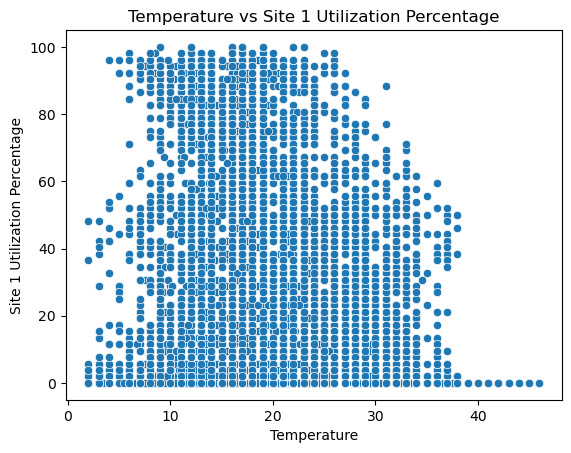

In [3]:
# Visualize how utilization and temperature correlate
sns.scatterplot(x='temperature', y='site1_utilization_percentage', data=Predict_utilization)
plt.title('Temperature vs Site 1 Utilization Percentage')
plt.xlabel('Temperature')
plt.ylabel('Site 1 Utilization Percentage')
plt.show()


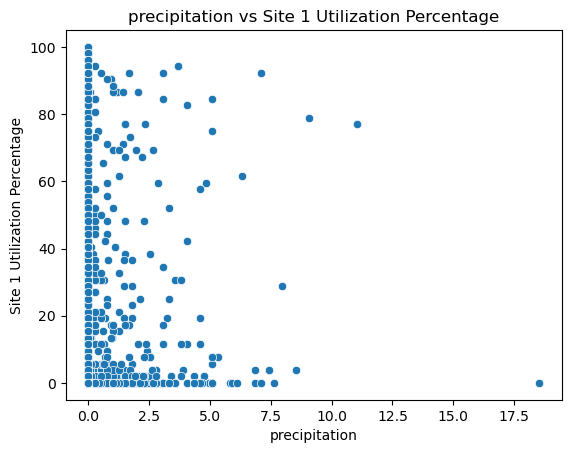

In [5]:
sns.scatterplot(x='precipitation', y='site1_utilization_percentage', data=Predict_utilization)
plt.title('precipitation vs Site 1 Utilization Percentage')
plt.xlabel('precipitation')
plt.ylabel('Site 1 Utilization Percentage')
plt.show()

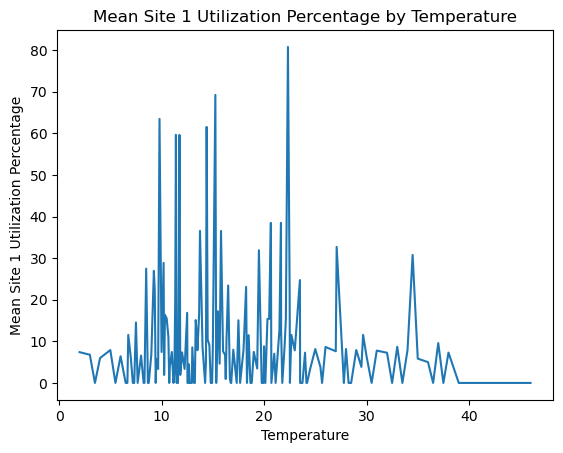

In [6]:
mean_utilization_by_temperature = Predict_utilization.groupby('temperature')['site1_utilization_percentage'].mean().reset_index()
sns.lineplot(x='temperature', y='site1_utilization_percentage', data=mean_utilization_by_temperature)
plt.title('Mean Site 1 Utilization Percentage by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Mean Site 1 Utilization Percentage')
plt.show()


In [7]:
columns_to_normalize = ['temperature', 'precipitation']

# Applying Min-Max scaling to normalize the selected columns
scaler = MinMaxScaler()
Predict_utilization[columns_to_normalize] = scaler.fit_transform(Predict_utilization[columns_to_normalize])

# Display the normalized DataFrame
print(Predict_utilization)


             date  month  hour  dayOfTheWeek  site1_utilization  \
0      2018-01-01      1     0             0                  0   
1      2018-01-01      1     1             0                  0   
2      2018-01-01      1     2             0                  0   
3      2018-01-01      1     3             0                  0   
4      2018-01-01      1     4             0                  0   
...           ...    ...   ...           ...                ...   
26299  2020-12-31     12    19             3                  0   
26300  2020-12-31     12    20             3                  0   
26301  2020-12-31     12    21             3                  0   
26302  2020-12-31     12    22             3                  0   
26303  2020-12-31     12    23             3                  0   

       site2_utilization  site1_utilization_percentage  \
0                      0                           0.0   
1                      0                           0.0   
2                    

C:\Users\joost\AppData\Local\Temp\ipykernel_13444\3740133451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['is_weekend'] = (filtered_data['dayOfTheWeek'] >= 5).astype(int)


Cross-Validation Mean Squared Error: 311.6677066156841


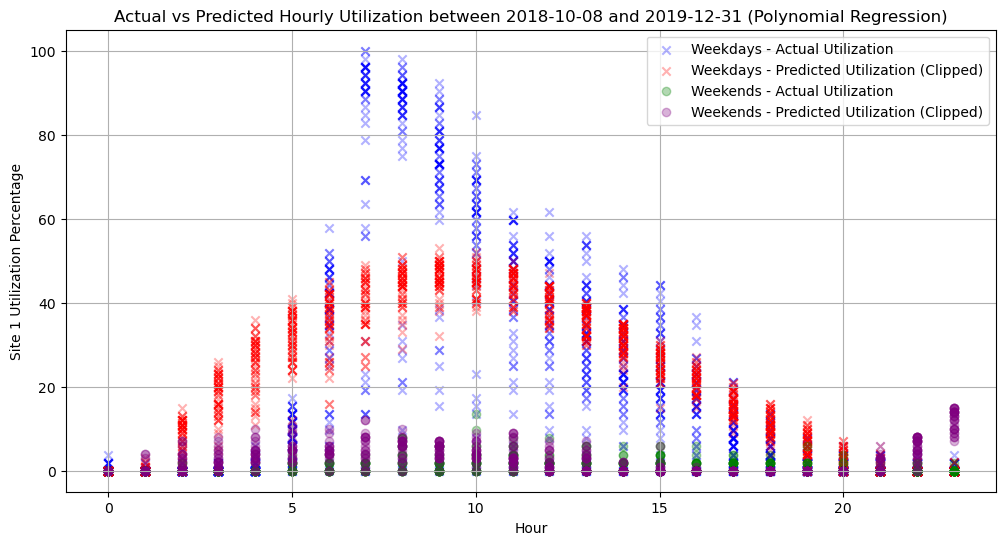

Mean Squared Error on Test Set: 237.44521732850498


In [15]:
date_filter = (Predict_utilization['date'] >= '2018-10-08') & (Predict_utilization['date'] < '2020-01-01')
filtered_data = Predict_utilization[date_filter]

# Create a new column to identify weekdays (0) and weekends (1)
filtered_data['is_weekend'] = (filtered_data['dayOfTheWeek'] >= 5).astype(int)

# Features (X) and target variable (y)
features = ['month', 'hour', 'is_weekend', 'temperature', 'precipitation']
target = 'site1_utilization_percentage'

X = filtered_data[features]
y = filtered_data[target]

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create a polynomial regression model with regularization parameter alpha
degree = 3  # Adjust the degree of the polynomial
alpha = 0.1  # Adjust the value of alpha based on your preference

# Fit the model to the training data using cross-validation
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), Ridge(alpha=alpha))
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f'Cross-Validation Mean Squared Error: {-np.mean(cv_scores)}')

# Fit the model to the training data
model.fit(X_train, y_train)

# Use the existing hourly timestamps for prediction
hourly_predictions = model.predict(X_test)

# Clip predictions at 0 using a custom function
clip_at_zero = np.vectorize(lambda x: max(x, 0))
hourly_predictions_clipped = clip_at_zero(hourly_predictions)

# Sort X_test by 'hour' for a smoother plot
X_test_sorted = X_test.sort_values('hour')

plt.figure(figsize=(12, 6))

# Plot the actual hourly utilization over a day for weekdays
plt.scatter(X_test[X_test['is_weekend'] == 0]['hour'], y_test[X_test['is_weekend'] == 0], marker='x', color='blue', alpha=0.3, label='Weekdays - Actual Utilization')

# Plot the clipped predicted hourly utilization over a day as red crosses for weekdays
plt.scatter(X_test_sorted[X_test_sorted['is_weekend'] == 0]['hour'], clip_at_zero(model.predict(X_test_sorted[X_test_sorted['is_weekend'] == 0])), marker='x', color='red', alpha=0.3, label='Weekdays - Predicted Utilization (Clipped)')

# Plot the actual hourly utilization over a day for weekends
plt.scatter(X_test[X_test['is_weekend'] == 1]['hour'], y_test[X_test['is_weekend'] == 1], marker='o', color='green', alpha=0.3, label='Weekends - Actual Utilization')

# Plot the clipped predicted hourly utilization over a day as red crosses for weekends
plt.scatter(X_test_sorted[X_test_sorted['is_weekend'] == 1]['hour'], clip_at_zero(model.predict(X_test_sorted[X_test_sorted['is_weekend'] == 1])), marker='o', color='purple', alpha=0.3, label='Weekends - Predicted Utilization (Clipped)')


plt.xlabel('Hour')
plt.ylabel('Site 1 Utilization Percentage')
plt.title('Actual vs Predicted Hourly Utilization between 2018-10-08 and 2019-12-31 (Polynomial Regression)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
mse = mean_squared_error(y_test, hourly_predictions_clipped)
print(f'Mean Squared Error on Test Set: {mse}')